# Make each level to each Curve CSV FILE

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_begin = []
num_row = []
start = 1
number_of_corner = 2
f_1 = 'beginner_expert_processedData/beginner/beginner_'
f_3 = '.csv'
num_begin = 19
curveList = [[103.9, 209.3], [316.6, 399.6], [425.3, 517.9], [590.5, 756.9], [1048.7, 1110.5], [1212.3, 1437.1]]

df_concat = pd.DataFrame()

for curve_num in range(start,number_of_corner):
#     print(num_row)
    for idx in range(1, num_begin+1):
        tmp_file = f_1+str(idx)+'_new2'+f_3
        df = pd.read_csv(tmp_file)
        df = df.dropna()
        
        tmp = df.astype(float)
        tmp['level'] =0
        
        tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]
        num_row.append(np.size(tmpcorner,0)) 
        
        df_begin.append(tmpcorner)
        df_concat = pd.concat([df_concat,df_begin[idx-1]])      
        
    df_concat.to_csv('cornerData/corner_'+str(curve_num+1)+'_begin'+'.csv')
    df_concat = pd.DataFrame()
    df_begin = []
    


In [3]:
df_exp = []
f_1 = 'beginner_expert_processedData/expert/expert_'
f_3 = '.csv'
num_exp = 19

df_concat = pd.DataFrame()

for curve_num in range(start,number_of_corner):
    for idx in range(1, num_exp+1):
        tmp_file = f_1+str(idx)+'_new2'+f_3
        df = pd.read_csv(tmp_file)
        df = df.dropna()

        tmp = df.astype(float)
        tmp['level'] =1

        tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]
        num_row.append(np.size(tmpcorner,0)) 

        df_exp.append(tmpcorner)
        df_concat = pd.concat([df_concat,df_exp[idx-1]])
    
    df_concat.to_csv('cornerData/corner_'+str(curve_num+1)+'_expert'+'.csv')
    df_concat = pd.DataFrame()
    df_exp = []

In [4]:
print(num_row)

[46, 57, 49, 43, 50, 54, 61, 58, 50, 51, 59, 68, 50, 48, 69, 59, 60, 48, 52, 51, 45, 46, 50, 53, 48, 47, 46, 44, 45, 52, 47, 45, 46, 47, 47, 43, 44, 43]


In [5]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import random



left_column = [
#'Time',
    'Distance','GPS Latitude','GPS Longitude','Damper Velocity (Calc) FL','Damper Velocity (Calc) FR','Damper Velocity (Calc) RL',
'Damper Velocity (Calc) RR','Corr Dist','Corr Dist (Unstretched)','Corr Speed','Brake Pos',
'CG Accel Lateral','CG Accel Longitudinal','CG Accel Vertical','CG Height','Camber FL','Camber FR','Camber RL','Camber RR','Car Coord X',
'Car Coord Y','Car Coord Z','Car Pos Norm','Chassis Pitch Angle','Chassis Pitch Rate','Chassis Roll Angle','Chassis Roll Rate',
'Chassis Velocity X','Chassis Velocity Y','Chassis Velocity Z','Chassis Yaw Rate','Drive Train Speed','Engine RPM','Ground Speed',
'Ride Height FL','Ride Height FR','Ride Height RL','Ride Height RR','Road Temp','Self Align Torque FL','Self Align Torque FR',
'Self Align Torque RL','Self Align Torque RR','Session Time Left','Steering Angle','Suspension Travel FL','Suspension Travel FR',
'Suspension Travel RL','Suspension Travel RR','Tire Load FL','Tire Load FR','Tire Load RL','Tire Load RR','Tire Loaded Radius FL',
'Tire Loaded Radius FR','Tire Loaded Radius RL','Tire Loaded Radius RR','Tire Pressure FL','Tire Pressure FR','Tire Pressure RL','Tire Pressure RR',
'Tire Rubber Grip FL','Tire Rubber Grip FR','Tire Rubber Grip RL','Tire Rubber Grip RR','Tire Slip Angle FL','Tire Slip Angle FR',
'Tire Slip Angle RL','Tire Slip Angle RR','Tire Slip Ratio FL','Tire Slip Ratio FR','Tire Slip Ratio RL','Tire Slip Ratio RR',
'Tire Temp Core FL','Tire Temp Core FR','Tire Temp Core RL','Tire Temp Core RR','Tire Temp Inner FL','Tire Temp Inner FR',
'Tire Temp Inner RL','Tire Temp Inner RR','Tire Temp Middle FL','Tire Temp Middle FR','Tire Temp Middle RL',
'Tire Temp Middle RR','Tire Temp Outer FL','Tire Temp Outer FR','Tire Temp Outer RL','Tire Temp Outer RR','Toe In FL',
'Toe In FR','Toe In RL','Toe In RR','Wheel Angular Speed FL','Wheel Angular Speed FR','Wheel Angular Speed RL','Wheel Angular Speed RR',
'CG Distance','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration','level']


#Hyper-parameters
num_epochs = 100
batches = 1
learning_rate = 0.001
input_size = len(left_column)-1 # left column except 'level'
output_size = 2 # Expert and Beginner
hidden_size = 128 # ?
num_layers = 2 
num_begin_train = 15*(number_of_corner-start)
num_exp_train = 15*(number_of_corner-start)
num_begin_test = num_begin*(number_of_corner-start) - num_begin_train
num_exp_test = num_exp*(number_of_corner-start) - num_exp_train

## Define GRU, Loss func and Optimizer
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer, output_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

gru = GRU(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)  


## Data Processing
array_x = []
array_y = []
input_x = []
input_y = []
n_row = []

df_tmp_begin = pd.DataFrame() 
df_tmp_exp = pd.DataFrame() 
for curve_num in range(start,number_of_corner):
    df_tmp_begin = pd.concat([df_tmp_begin,pd.read_csv('cornerData/corner_'+str(curve_num+1)+'_begin.csv')])
    df_tmp_exp   = pd.concat([df_tmp_exp,pd.read_csv('cornerData/corner_'+str(curve_num+1)+'_expert.csv')])    
df_curve1 = pd.concat([df_tmp_begin, df_tmp_exp], ignore_index=True) 
df_curve1 = df_curve1.loc[:,left_column]
df_curve1_saved = df_curve1.loc[:,left_column] # data backup
df_curve1.to_csv('cornerData/corner_'+'_dfcurve1'+'.csv')


for i in range(0,num_begin*(number_of_corner-start) + num_exp*(number_of_corner-start)):
    x = df_curve1_saved.loc[0:num_row[i]-1]
    df_curve1_saved.drop(range(0,num_row[i]),inplace=True)
    df_curve1_saved.reset_index(drop=True, inplace=True)
    y = x.pop('level')
    array_x.append(x)
    array_y.append(y)

    
## Randomize sequence 
sequence = np.arange(num_begin*(number_of_corner-start) + num_exp*(number_of_corner-start))
np.random.shuffle(sequence)
print(sequence)

for i in sequence:
    input_x.append(array_x[i])
    input_y.append(array_y[i])
    n_row.append(num_row[i])



## Train 
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i in range(0,num_begin_train + num_exp_train):

        # array type (numpy)
        X = np.array(input_x[i])
        X = X.reshape(-1,n_row[i],input_size)
        Y = np.array(input_y[i])   
        
        # tensor type (pytorch)
        X = torch.from_numpy(X)
        X = X.float()
        Y = torch.tensor([Y[0]])
        
        optimizer.zero_grad()
        output = gru(X)
        loss = criterion(output, Y)
        
        # Backward and optimize
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        loss_list.append(loss.data)
        iteration_list.append(count)
#         accuracy_list.append(accuracy)
        print (f'Loss: {loss.item():.4f}')

## Test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for i in range(num_begin_train + num_exp_train, num_begin*(number_of_corner-start) + num_exp*(number_of_corner-start)):
        
        # array type (numpy)
        X = np.array(input_x[i])
        X = X.reshape(-1,n_row[i],input_size)
        Y = np.array(input_y[i])   

        # tensor type (pytorch)
        X = torch.from_numpy(X)
        X = X.float()
        Y = torch.tensor([Y[0]])

        output = gru(X)
        _, predicted = torch.max(output.data, 1)
        n_samples += Y.size(0)
        n_correct += (predicted == Y).sum().item()
        


    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {num_begin_test + num_exp_test} test images: {acc} %')



[21 12 22  8  6 26 15 29 23 27 32 10 34 14 13 33 24 31 36  3 17 11 18  7
  4 30 35 37  9  1 25 28  0 19  2 16 20  5]
Loss: 0.8862
Loss: 1.0890
Loss: 0.6120
Loss: 1.0635
Loss: 0.9158
Loss: 0.5792
Loss: 0.4807
Loss: 0.9619
Loss: 0.7399
Loss: 0.5738
Loss: 0.5971
Loss: 0.4224
Loss: 0.3854
Loss: 1.0526
Loss: 0.8111
Loss: 0.3657
Loss: 0.3812
Loss: 0.4420
Loss: 0.2289
Loss: 1.2615
Loss: 1.0663
Loss: 0.8423
Loss: 1.2120
Loss: 1.0017
Loss: 0.3210
Loss: 1.1513
Loss: 0.5947
Loss: 0.4536
Loss: 0.7392
Loss: 0.2549
Loss: 0.8275
Loss: 0.3314
Loss: 1.4015
Loss: 0.3997
Loss: 0.2259
Loss: 0.7371
Loss: 0.1018
Loss: 1.6247
Loss: 1.1955
Loss: 0.4300
Loss: 0.6327
Loss: 0.2267
Loss: 0.3425
Loss: 1.3782
Loss: 0.8597
Loss: 0.3550
Loss: 0.3386
Loss: 0.3473
Loss: 0.1322
Loss: 1.5726
Loss: 0.8419
Loss: 0.6669
Loss: 1.0954
Loss: 1.1354
Loss: 0.2950
Loss: 0.8694
Loss: 0.2645
Loss: 0.2490
Loss: 0.9520
Loss: 0.3996
Loss: 0.6980
Loss: 0.3649
Loss: 1.2139
Loss: 0.4468
Loss: 0.2978
Loss: 0.6192
Loss: 0.1228
Loss: 1.6727

Loss: 0.0061
Loss: 0.0053
Loss: 0.4659
Loss: 0.0366
Loss: 1.0557
Loss: 0.1837
Loss: 0.8936
Loss: 1.6268
Loss: 0.2178
Loss: 1.0654
Loss: 0.0103
Loss: 1.8805
Loss: 3.5776
Loss: 2.5033
Loss: 1.8918
Loss: 0.0153
Loss: 1.5387
Loss: 0.1729
Loss: 0.0751
Loss: 0.7676
Loss: 0.8616
Loss: 0.7453
Loss: 0.3497
Loss: 1.2187
Loss: 1.0296
Loss: 0.8176
Loss: 1.4095
Loss: 1.4338
Loss: 0.7096
Loss: 0.3698
Loss: 0.3225
Loss: 0.3575
Loss: 0.7991
Loss: 0.4631
Loss: 0.7836
Loss: 0.4855
Loss: 0.8998
Loss: 0.5086
Loss: 0.4698
Loss: 0.6938
Loss: 0.2558
Loss: 0.7671
Loss: 1.1406
Loss: 0.7052
Loss: 0.4960
Loss: 0.3128
Loss: 0.4344
Loss: 0.7494
Loss: 0.4051
Loss: 0.3112
Loss: 0.4234
Loss: 0.5233
Loss: 0.2392
Loss: 1.1398
Loss: 0.6761
Loss: 0.3919
Loss: 0.9593
Loss: 0.9454
Loss: 0.2755
Loss: 0.5943
Loss: 0.4313
Loss: 0.4526
Loss: 0.5534
Loss: 0.2113
Loss: 1.0070
Loss: 0.3320
Loss: 1.0730
Loss: 0.4158
Loss: 0.4468
Loss: 0.5237
Loss: 0.1961
Loss: 0.5844
Loss: 0.9742
Loss: 0.4387
Loss: 0.2947
Loss: 0.2595
Loss: 0.2566

Loss: 0.0196
Loss: 1.0496
Loss: 0.1036
Loss: 1.0821
Loss: 0.4635
Loss: 0.4535
Loss: 0.0241
Loss: 0.0304
Loss: 0.0099
Loss: 1.1113
Loss: 0.0238
Loss: 0.0214
Loss: 0.0076
Loss: 0.0178
Loss: 0.6051
Loss: 0.0052
Loss: 0.0169
Loss: 0.8276
Loss: 0.7548
Loss: 0.0098
Loss: 0.8755
Loss: 0.0116
Loss: 0.0016
Loss: 0.2762
Loss: 0.9219
Loss: 0.0085
Loss: 0.0391
Loss: 0.0143
Loss: 0.0156
Loss: 0.5766
Loss: 0.0176
Loss: 1.0445
Loss: 0.0966
Loss: 1.0792
Loss: 0.4652
Loss: 0.4526
Loss: 0.0217
Loss: 0.0267
Loss: 0.0088
Loss: 1.1100
Loss: 0.0217
Loss: 0.0196
Loss: 0.0069
Loss: 0.0164
Loss: 0.6007
Loss: 0.0050
Loss: 0.0156
Loss: 0.8290
Loss: 0.7579
Loss: 0.0091
Loss: 0.8615
Loss: 0.0106
Loss: 0.0015
Loss: 0.2707
Loss: 0.9144
Loss: 0.0079
Loss: 0.0362
Loss: 0.0128
Loss: 0.0139
Loss: 0.5904
Loss: 0.0164
Loss: 1.0187
Loss: 0.0937
Loss: 1.0543
Loss: 0.4776
Loss: 0.4610
Loss: 0.0188
Loss: 0.0242
Loss: 0.0079
Loss: 1.1075
Loss: 0.0191
Loss: 0.0173
Loss: 0.0062
Loss: 0.0146
Loss: 0.5971
Loss: 0.0047
Loss: 0.0141

Loss: 0.0164
Loss: 0.9808
Loss: 0.1269
Loss: 0.9947
Loss: 0.4987
Loss: 0.4878
Loss: 0.0051
Loss: 0.0228
Loss: 0.0025
Loss: 1.0648
Loss: 0.0053
Loss: 0.0050
Loss: 0.0055
Loss: 0.0045
Loss: 0.5491
Loss: 0.0054
Loss: 0.0044
Loss: 0.8964
Loss: 0.8366
Loss: 0.0029
Loss: 0.7432
Loss: 0.0033
Loss: 0.0006
Loss: 0.2651
Loss: 0.8082
Loss: 0.0032
Loss: 0.0073
Loss: 0.0036
Loss: 0.0038
Loss: 0.5837
Loss: 0.0086
Loss: 0.9837
Loss: 0.1190
Loss: 1.0005
Loss: 0.4933
Loss: 0.4801
Loss: 0.0048
Loss: 0.0139
Loss: 0.0024
Loss: 1.0714
Loss: 0.0050
Loss: 0.0047
Loss: 0.0043
Loss: 0.0042
Loss: 0.5474
Loss: 0.0050
Loss: 0.0042
Loss: 0.8943
Loss: 0.8345
Loss: 0.0027
Loss: 0.7413
Loss: 0.0028
Loss: 0.0005
Loss: 0.2641
Loss: 0.8066
Loss: 0.0028
Loss: 0.0068
Loss: 0.0034
Loss: 0.0036
Loss: 0.5915
Loss: 0.0069
Loss: 0.9685
Loss: 0.1176
Loss: 0.9822
Loss: 0.5012
Loss: 0.4855
Loss: 0.0045
Loss: 0.0116
Loss: 0.0022
Loss: 1.0647
Loss: 0.0047
Loss: 0.0045
Loss: 0.0038
Loss: 0.0041
Loss: 0.5468
Loss: 0.0047
Loss: 0.0040

Loss: 0.5166
Loss: 0.5380
Loss: 0.0026
Loss: 0.0051
Loss: 0.0013
Loss: 0.9438
Loss: 0.0027
Loss: 0.0026
Loss: 0.0021
Loss: 0.0024
Loss: 0.6133
Loss: 0.0032
Loss: 0.0024
Loss: 0.7120
Loss: 0.7449
Loss: 0.0021
Loss: 0.7819
Loss: 0.0007
Loss: 0.0003
Loss: 0.1767
Loss: 0.7910
Loss: 0.0014
Loss: 0.0049
Loss: 0.0022
Loss: 0.0023
Loss: 0.6674
Loss: 0.0023
Loss: 0.8580
Loss: 0.0085
Loss: 0.9734
Loss: 0.5050
Loss: 0.5030
Loss: 0.0028
Loss: 0.0026
Loss: 0.0014
Loss: 1.0388
Loss: 0.0029
Loss: 0.0028
Loss: 0.0018
Loss: 0.0025
Loss: 0.5346
Loss: 0.0025
Loss: 0.0025
Loss: 0.7911
Loss: 0.8280
Loss: 0.0021
Loss: 0.7186
Loss: 0.0007
Loss: 0.0003
Loss: 0.0936
Loss: 0.7646
Loss: 0.0012
Loss: 0.0029
Loss: 0.0020
Loss: 0.0021
Loss: 0.6732
Loss: 0.0020
Loss: 0.8561
Loss: 0.0048
Loss: 1.0672
Loss: 0.5166
Loss: 0.5302
Loss: 0.0025
Loss: 0.0027
Loss: 0.0012
Loss: 0.9407
Loss: 0.0025
Loss: 0.0024
Loss: 0.0020
Loss: 0.0022
Loss: 0.6126
Loss: 0.0027
Loss: 0.0022
Loss: 0.6978
Loss: 0.7430
Loss: 0.0019
Loss: 0.7542

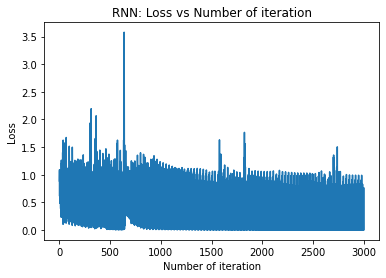

In [6]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()
# print(iteration_list)
# # visualization accuracy 
# plt.plot(iteration_list,accuracy_list,color = "red")
# plt.xlabel("Number of iteration")
# plt.ylabel("Accuracy")
# plt.title("RNN: Accuracy vs Number of iteration")
# plt.savefig('graph.png')
# plt.show()

In [7]:
food = 'bread'
vars()['cat'] = 123
print(cat)
print(type(cat))

123
<class 'int'>


In [8]:
a = pd.DataFrame() 
print(a)

Empty DataFrame
Columns: []
Index: []


In [9]:
s = pd.Series([0, 1, np.nan, 10])
s.interpolate()

0     0.0
1     1.0
2     5.5
3    10.0
dtype: float64